In [1]:
!git clone https://github.com/AbhayVAshokan/Road-Segmentation-Dataset.git

Cloning into 'Road-Segmentation-Dataset'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
^C


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import json
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [ ]:
# Set some parameters
im_width = 128
im_height = 128
border = 5
path_train = '/content/Road-Segmentation-Dataset/train'
path_test = '/content/Road-Segmentation-Dataset/test'

## Converting labels into masks

<ul>
<li>Data (label) is available in the IDD dataset in JSON format. Each value represents a coordinate in the image. The coordinates are connected to form a region and it is colored with a color (200, 0, 0). After this operation, binary thresholding is done to get the output as either black or white. The output is called as a mask. </li>

<li>
Visually, the mask represents the region of interest (The region that we need to detect).
</li>

<li>
In the JSON file, there are several classes available (road, car, autorickshaw, etc). As a first step, only the "road" property is extracted from the JSON file.
</li>
</ul>

In [ ]:
def create_mask(data):
    w = data["imgWidth"]
    h = data["imgHeight"]
    image = np.zeros((w, h))
    
    region = data["objects"]
    for i in range(len(region)):
        if region[i]["label"] == "road":
            road = region[i]["polygon"]
            break

    image = Image.new("1", (w, h))
    draw = ImageDraw.Draw(image)

    shape = tuple(map(tuple, road))
    draw.polygon((shape), fill=200)

    image = np.array(image)
    image = Image.fromarray(np.uint8(plt.cm.gist_earth(image)*255))
    mask = np.array(image)

    mask = 255 - mask[:, :, 2]
    ret,mask = cv2.threshold(mask,250,255,cv2.THRESH_BINARY)
    return mask 


In [ ]:
# Get and resize train images and annotation
def get_data(path, train=True):
    ids = next(os.walk(path + "/image"))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    
    # Masks are generated only for the training data
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
   
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/image/' + id_, color_mode = "grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

        # Load annotation
        if train:
            an_ = id_[:6] + "_gtFine_polygons.json"
            with open(path_train + "/annotation/" + an_) as f:
                data = json.load(f)
            mask = img_to_array(create_mask(data))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)


Getting and resizing images ... 



Done!


In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)

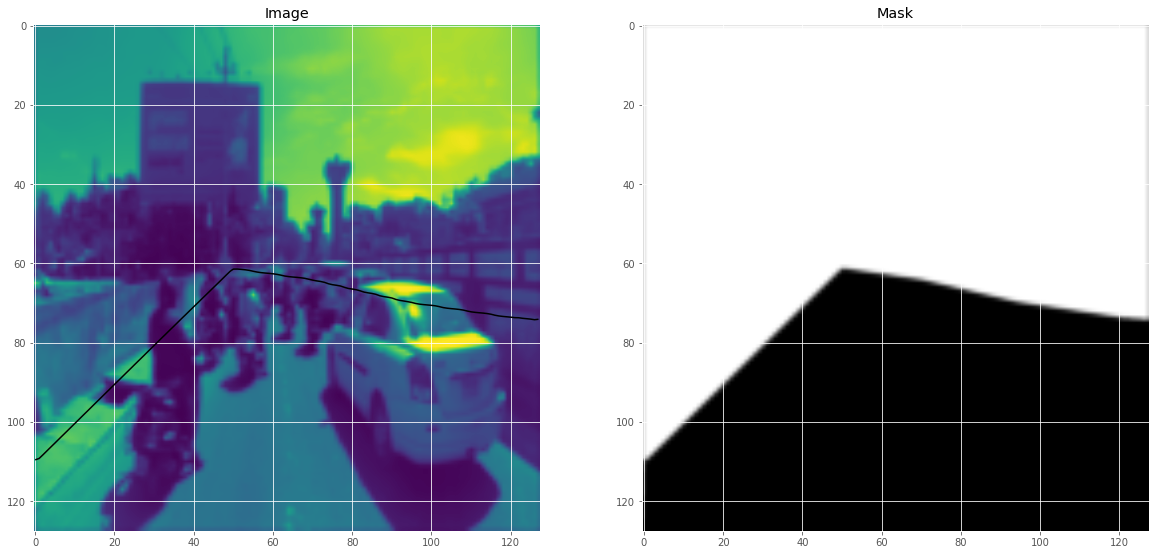

In [ ]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Image')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Mask');

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [ ]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
# model = get_unet()
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
___________________________________________________________________

## Callbacks

<ul>

<li>
EarlyStopping: Stop the training process when the loss function has stopped imporving for 10 continuous epochs.
</li>

<li>
ReduceLROnPlateau: Reduce learning rate when there is no change in metric (for three consequtive epochs).
</li>

<li>
ModelCheckpoint: Save the model whenever the epoch has improved the loss function. Advantage: We can force stop the training mid way and still have a model as ouput.
</li>

</ul>

In [ ]:
    callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 1487 samples, validate on 263 samples
Epoch 1/100
1487/1487 [==============================] - 4s 2ms/step - loss: 0.1286 - acc: 0.8904 - val_loss: 0.1723 - val_acc: 0.8746

Epoch 00001: val_loss improved from inf to 0.17227, saving model to model.h5
Epoch 2/100
1487/1487 [==============================] - 4s 2ms/step - loss: 0.1239 - acc: 0.8923 - val_loss: 0.1824 - val_acc: 0.8698

Epoch 00002: val_loss did not improve from 0.17227
Epoch 3/100
1487/1487 [==============================] - 4s 2ms/step - loss: 0.1200 - acc: 0.8938 - val_loss: 0.1627 - val_acc: 0.8790

Epoch 00003: val_loss improved from 0.17227 to 0.16273, saving model to model.h5
Epoch 4/100
1487/1487 [==============================] - 4s 2ms/step - loss: 0.1155 - acc: 0.8957 - val_loss: 0.1697 - val_acc: 0.8759

Epoch 00004: val_loss did not improve from 0.16273
Epoch 5/100
1487/1487 [==============================] - 4s 2ms/step - loss: 0.1106 - acc: 0.8974 - val_loss: 0.1726 - val_acc: 0.8744

Epoch 00005: 

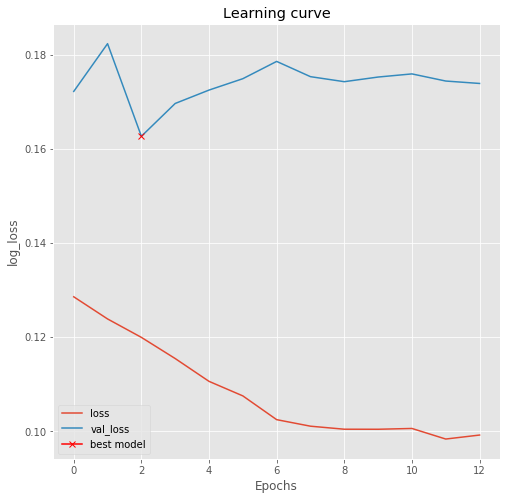

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# Load best model
model.load_weights('model.h5')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

263/263 [==============================] - 0s 669us/step


[0.16272999482236433, 0.878951736729408]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

263/263 [==============================] - 0s 709us/step


In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Mask Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Mask Predicted binary');

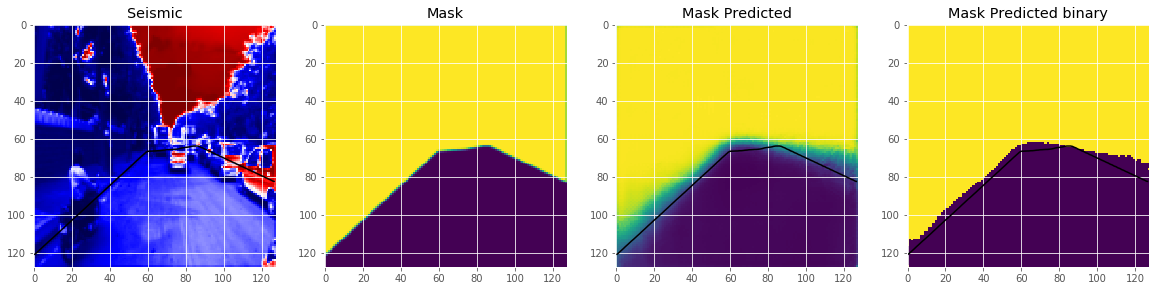

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

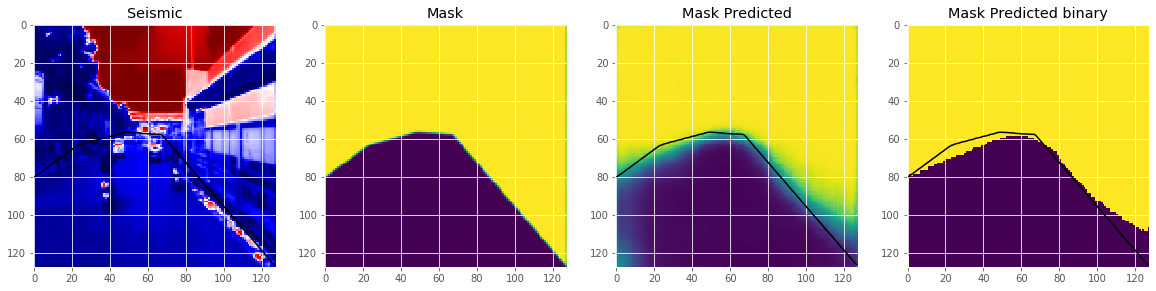

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

In [ ]:
import h5py
model.save('model.h5')
!ls

model.h5  model-tgs-salt.h5  Road-Segmentation-Dataset	sample_data


In [ ]:
!ls

model.h5  model-tgs-salt.h5  Road-Segmentation-Dataset	sample_data


In [ ]:
from google.colab import files
files.download("model.h5")